## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon Oct 23 03:13:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

zsh:1: command not found: nvcc
torch:  2.1 ; cuda:  2.1.0


In [1]:
import os
HOME = os.getcwd()
print(HOME)

/Users/jeongho/github/yolov8/model


## Install YOLOv8

In [3]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/78.2 GB disk)


## Install Supervision

In [2]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


In [3]:
# 수정하기
# input 비디오 이름 설정
SOURCE_VIDEO_PATH = f"{HOME}/data/tent-counting.mp4"
# output 비디오 이름 설정
TARGET_VIDEO_PATH = f"{HOME}/data/tent-counting-result.mp4"

## Load pre-trained YOLOv8 model

In [4]:
# Custom 데이터로 fintuning진행한 weights 업로드 이후 unzip
!unzip /content/weights.zip

unzip:  cannot find or open /content/weights.zip, /content/weights.zip.zip or /content/weights.zip.ZIP.


In [5]:
from ultralytics import YOLO
# settings
MODEL = "runs/detect/train/weights/best.pt"
model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

Let's start YOLOv8 inference pipeline.


0: 736x1280 6 Tents, 383.2ms
Speed: 6.3ms preprocess, 383.2ms inference, 10.3ms postprocess per image at shape (1, 3, 736, 1280)


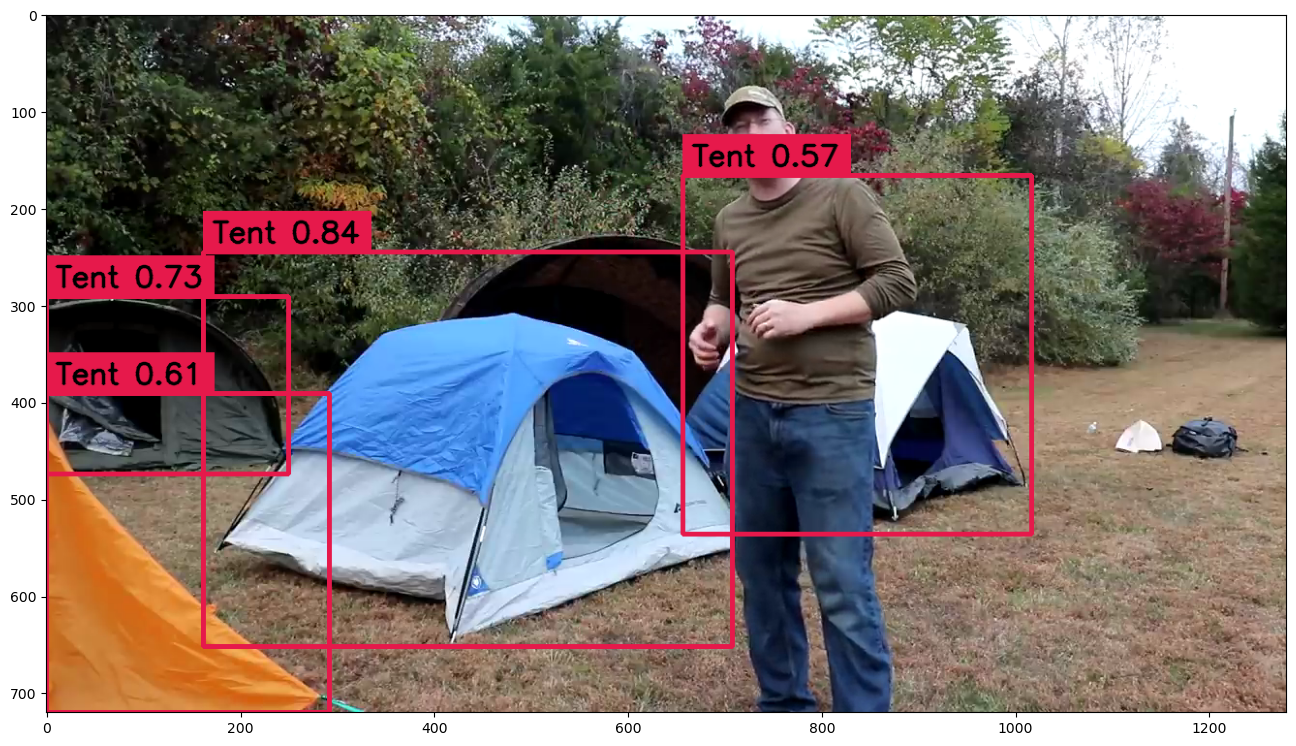

In [6]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.55)]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=2, text_scale=1)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

**NOTE:** Now we can add a polygon zone to the scene and visualize it.

In [9]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=10306)


0: 736x1280 6 Tents, 448.1ms
Speed: 5.1ms preprocess, 448.1ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)


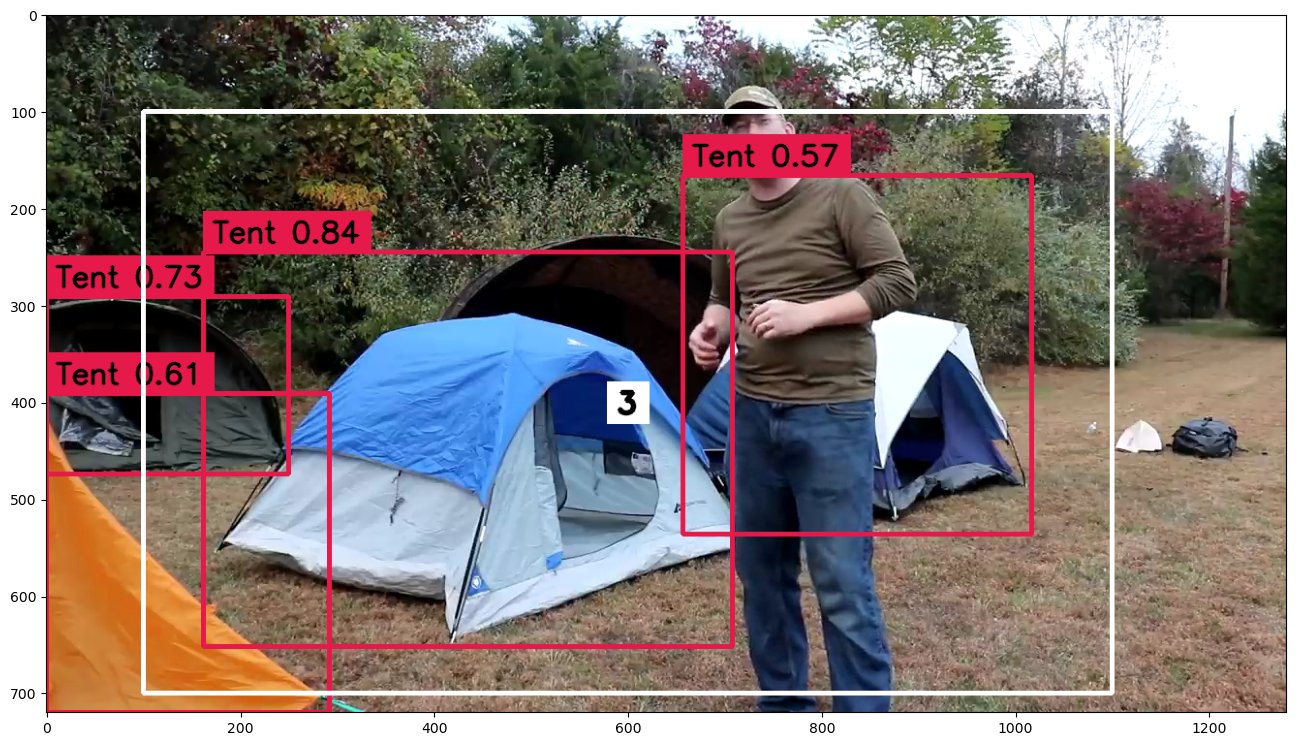

In [10]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [100, 700],
    [100, 100],
    [1100, 100],
    [1100, 700]
])

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=2, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=3, text_thickness=3, text_scale=1)

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[(detections.class_id == 0) & (detections.confidence > 0.55)]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=2, text_scale=1)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

## process the whole video.

In [ ]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [100, 700],
    [100, 100],
    [1100, 100],
    [1100, 700]
])
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=2, text_scale=1)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=3, text_thickness=3, text_scale=1)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[(detections.class_id == 0) & (detections.confidence > 0.55)]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=2, text_scale=1)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    print(zone.current_count) # 개수가 저장되어 있는 곳
    return frame

sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path=TARGET_VIDEO_PATH, callback=process_frame)

from IPython import display
display.clear_output()